# SMS Spam Collection Data Set from UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]

In [3]:
print(len(messages))

5574


In [4]:
# Print the first 10 messages
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

## Exploratory Data Analysis

In [5]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=["label", "message"])

In [6]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [9]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualization

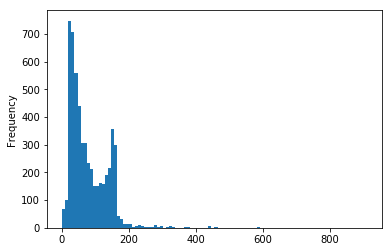

In [10]:
messages['length'].plot(bins=100, kind='hist') 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7F6C4D2E8>,
      dtype=object)

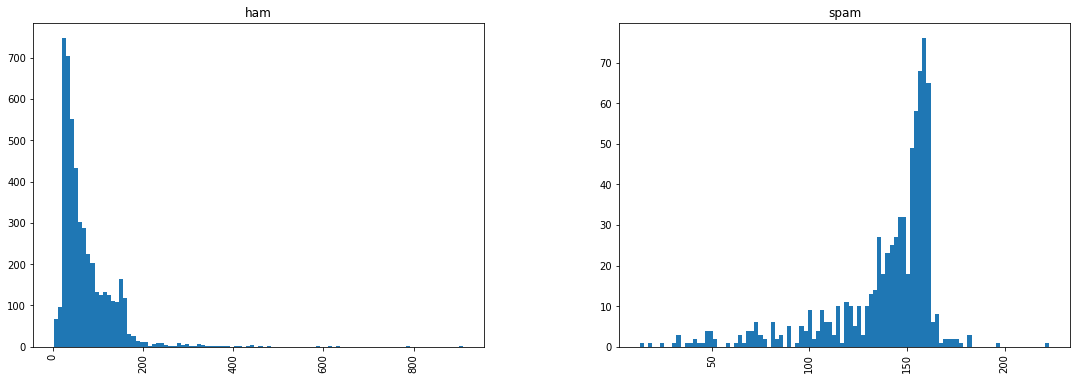

In [11]:
messages.hist(column='length', by='label', bins=100,figsize=(18,6))

## Tokenization

In [12]:
from nltk.corpus import stopwords
import string
mess = 'Sample message! Notice: it has punctuation.'
nopunc = [char for char in mess if char not in string.punctuation]
nopunc = ''.join(nopunc)

In [13]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation] #remove punc
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')] #remove stopwords

In [14]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11425


In [18]:
messages_bow = bow_transformer.transform(messages['message'])

In [19]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [20]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

In [22]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [23]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [24]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Model Training & Model Evaluation with Data Pipeline

In [25]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [26]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [28]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001F7F6CEE730>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [29]:
predictions = pipeline.predict(msg_test)

In [30]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1000
        spam       0.71      1.00      0.83       115

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.86      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

